## <u>*Regression Modelling for Frequency as a Target Feature*</u>

In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Auto_Insurance\Notebooks\Data_Analysis\3_EDA.ipynb

In [2]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


---

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Regression Models to use :*</u>

In [4]:
models = {
                "Random Forest": RandomForestRegressor(random_state=41),
                "Decision Tree": DecisionTreeRegressor(random_state=41),
                "Gradient Boosting": GradientBoostingRegressor(random_state=41),
                "XGBRFRegressor":XGBRFRegressor(random_state=41),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=41),
                "AdaBoost Regressor": AdaBoostRegressor(random_state=41),
            }

#### *A.2. <br> <u>Regression Models spaces preperartion to use in hyperopt :*</u>

In [5]:
space_rf = {    
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['poisson', 'squared_error','friedman_mse','absolute_error']),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features',range(1, 4)),
    'bootstrap': hp.choice('bootstrap', [True, False])
    }


space_dt = {
    #'criterion': hp.choice('criterion', ['poisson', 'squared_error','friedman_mse','absolute_error']),
    #'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features',range(1, 4)),
    }

space_XGBRFRegressor = {
  'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

space_catboost = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}
   

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0)
}


---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>LabelEncoding for categorical features :*</u>

In [6]:
LabelEncoder_cat = LabelEncoder()
for col in df5:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5[col]=LabelEncoder_cat.fit_transform(df5[col])

#### *B.2. <br> <u>Define x & y features :*</u>

In [7]:
x=df5.drop("severity",axis=1)
y=df5["severity"]

#### *B.3. <br> <u>data splitting (training & testing) :*</u>

In [8]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3,random_state=41)

---

### *C. <br> <u>Modelling:*</u>

* *Note : Data scalling is not required as we are applying Tree -based models*

#### *C.1 <br> <u>* *XGBRFRegression:*</u>

In [9]:
def model_XGBRFRegressor(space_XGBRFRegressor):
    mae_scores =[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                n_estimators=int(space_XGBRFRegressor['n_estimators']),
                learning_rate=float(space_XGBRFRegressor["learning_rate"]), 
                max_depth=int(space_XGBRFRegressor['max_depth']),
                min_child_weight=int(space_XGBRFRegressor['min_child_weight']),
                subsample=float(space_XGBRFRegressor['subsample']),
                gamma=float(space_XGBRFRegressor['gamma']),
                colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                reg_alpha=float(space_XGBRFRegressor['reg_alpha']),
                reg_lambda=float(space_XGBRFRegressor['reg_lambda'])))                   
                                    

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }

In [10]:
def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                n_estimators=int(best_model_XGBRFRegressor['n_estimators']),
                learning_rate=float(best_model_XGBRFRegressor["learning_rate"]), 
                max_depth=int(best_model_XGBRFRegressor['max_depth']),
                min_child_weight=int(best_model_XGBRFRegressor['min_child_weight']),
                subsample=float(best_model_XGBRFRegressor['subsample']),
                gamma=float(best_model_XGBRFRegressor['gamma']),
                colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                reg_alpha=float(best_model_XGBRFRegressor['reg_alpha']),
                reg_lambda=float(best_model_XGBRFRegressor['reg_lambda']))) 
                 
                  ])
    
    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score) 

In [11]:
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=10)
model_XGBRFRegressor_best(best_model_XGBRFRegressor)

100%|██████████| 10/10 [00:07<00:00,  1.41trial/s, best loss: 76.95060344406902]
model_XGBRFRegressor_best MAE: 85.8674672672028
 Accuracy of the model_XGBRFRegressor_best is 84.35


---

#### *C.2 <br> <u>* *RandomForestRegressor:*</u>

In [20]:
def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"]),                                                     
                                    #criterion=str(space_rf['criterion']),
                                    min_samples_split=float(space_rf['min_samples_split']),
                                    min_samples_leaf=float(space_rf['min_samples_leaf']),
                                    #max_features=int(space_rf['max_features']),
                                    #bootstrap=int(space_rf['bootstrap'])
                                    ))

                                    ])
                                                 
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }  

In [21]:
def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"]),                                                     
                                    #criterion=str(best_model_rf['criterion']),
                                    min_samples_split=float(best_model_rf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf['min_samples_leaf']),
                                    #max_features=int(best_model_rf['max_features']),
                                    #bootstrap=int(best_model_rf['bootstrap'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) 

In [22]:
best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=10)
model_rf_best(best_model_rf)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:04<00:00,  2.42trial/s, best loss: 241.37950835996946]
model_rf_best MAE: 241.4344842924074
 Accuracy of the model_rf_best is 0.21


---

#### *C.3 <br> <u>* *DecisionTreeRegressor:*</u>

In [23]:
def model_DT(space_dt):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("DecisionTreeRegressor",DecisionTreeRegressor(
                                    #criterion=str(space_dt['criterion']),
                                    #splitter=str(space_dt["splitter"]),                                           
                                    max_depth=int(space_dt['max_depth']),
                                    min_samples_split=float(space_dt['min_samples_split']),
                                    min_samples_leaf=float(space_dt['min_samples_leaf']),
                                    #max_features=int(space_dt['max_features'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 


In [24]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("DecisionTreeRegressor",DecisionTreeRegressor(
                                    #criterion=str(best_model_DT['criterion']),
                                    #splitter=str(best_model_DT["splitter"]),                                           
                                    max_depth=int(best_model_DT['max_depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf'])
                                    #max_features=int(best_model_DT['max_features'])
                                    ))])


    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_DT_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('DecisionTreeRegressor MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_DecisionTreeRegressor_best is %.2f" %score)                                
    

In [25]:
best_model_DT = fmin(fn=model_DT, space=space_dt, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:00<00:00, 38.31trial/s, best loss: 241.2919214910055]
DecisionTreeRegressor MAE: 241.2919214910055
 Accuracy of the model_DecisionTreeRegressor_best is 0.22


---

#### *C.4 <br> <u>* *CatBoostRegressor:*</u>

In [18]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations']),
                                    l2_leaf_reg=float(space_catboost['l2_leaf_reg']),
                                    border_count=int(space_catboost['border_count']),
                                    bagging_temperature=float(space_catboost['bagging_temperature']),
                                    random_strength=float(space_catboost['random_strength'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

In [19]:
def model_catboost_best(best_space_catboost):
    y_catboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_space_catboost['learning_rate']),
                                    depth=int(best_space_catboost["depth"]),                                                       
                                    iterations=int(best_space_catboost['iterations']),
                                    l2_leaf_reg=float(best_space_catboost['l2_leaf_reg']),
                                    border_count=int(best_space_catboost['border_count']),
                                    bagging_temperature=float(best_space_catboost['bagging_temperature']),
                                    random_strength=float(best_space_catboost['random_strength'])))
                                    ])
    

    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_catboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('catboost MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the y_catboost_best is %.2f" %score)  

In [20]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 921.1653278	total: 147ms	remaining: 25s
1:	learn: 826.8736622	total: 151ms	remaining: 12.7s
2:	learn: 744.8766654	total: 154ms	remaining: 8.63s
3:	learn: 673.8822048	total: 157ms	remaining: 6.57s
4:	learn: 613.3480458	total: 161ms	remaining: 5.33s
5:	learn: 561.0233917	total: 164ms	remaining: 4.5s
6:	learn: 516.4502760	total: 167ms	remaining: 3.91s
7:	learn: 472.6385720	total: 170ms	remaining: 3.46s
8:	learn: 435.9302312	total: 173ms	remaining: 3.12s
9:	learn: 407.1653956	total: 177ms	remaining: 2.85s
10:	learn: 380.6360587	total: 180ms	remaining: 2.62s
11:	learn: 359.5145913	total: 183ms	remaining: 2.43s
12:	learn: 341.0818763	total: 186ms	remaining: 2.27s
13:	learn: 325.4568548	total: 190ms	remaining: 2.13s
14:	learn: 312.3199855	total: 193ms	remaining: 2.01s
15:	learn: 297.4786175	total: 196ms	remaining: 1.9s
16:	learn: 286.0341377	total: 199ms	remaining: 1.81s
17:	learn: 277.4407881	total: 203ms	remaining: 1.73s
18:	le

In [21]:
model_catboost_best(best_model_catboost)

0:	learn: 744.6818023	total: 11.3ms	remaining: 985ms
1:	learn: 643.6491917	total: 23.5ms	remaining: 1.01s
2:	learn: 591.8904767	total: 33.8ms	remaining: 958ms
3:	learn: 570.0767832	total: 48.3ms	remaining: 1.01s
4:	learn: 558.0029090	total: 64.2ms	remaining: 1.07s
5:	learn: 548.9325668	total: 78.9ms	remaining: 1.08s
6:	learn: 537.9324997	total: 95.7ms	remaining: 1.11s
7:	learn: 534.2615777	total: 110ms	remaining: 1.1s
8:	learn: 531.5942430	total: 125ms	remaining: 1.1s
9:	learn: 531.4306120	total: 142ms	remaining: 1.11s
10:	learn: 524.5527207	total: 170ms	remaining: 1.19s
11:	learn: 516.9197384	total: 188ms	remaining: 1.19s
12:	learn: 509.7796566	total: 205ms	remaining: 1.18s
13:	learn: 507.6935644	total: 223ms	remaining: 1.18s
14:	learn: 504.5396917	total: 239ms	remaining: 1.16s
15:	learn: 499.4905104	total: 255ms	remaining: 1.15s
16:	learn: 491.9044069	total: 275ms	remaining: 1.15s
17:	learn: 488.7450207	total: 301ms	remaining: 1.17s
18:	learn: 484.8790748	total: 330ms	remaining: 1.2s

---

#### *C.5 <br> <u>* *AdaBoostRegressor:*</u>

In [26]:
def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
    
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

In [27]:
def model_adaboost_best(best_space_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_space_adaboost['n_estimators']),
                                    learning_rate=float(best_space_adaboost["learning_rate"])
                                    ))])
    

    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('adaboost MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the y_adaboost_best is %.2f" %score)  

In [28]:
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=10)
model_adaboost_best(best_model_adaboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [01:10<00:00,  7.04s/trial, best loss: 39.56050354896849]
adaboost MAE: 33.005165444040514
 Accuracy of the y_adaboost_best is 96.19


---

### *D <br> <u>* *running Results:*</u>

### *D.1 <br> <u>* *best Results:*</u>

---

In [29]:
y_AdaBoostRegressor_model_best=[]
AdaBoostRegressor_model = AdaBoostRegressor(
                                    n_estimators=int(best_model_adaboost['n_estimators']),
                                    learning_rate=float(best_model_adaboost["learning_rate"]))

                                                                               
AdaBoostRegressor_model.fit(xtrain,ytrain)
mae_result=mean_absolute_error(ytest,AdaBoostRegressor_model.predict(xtest))
y_pred=AdaBoostRegressor_model.predict(xtest)
y_AdaBoostRegressor_model_best.append(y_pred)
print(mae_result)
score = r2_score(ytest, y_pred)*100
print(" r2_score of the model is %.2f" %score)

33.42602313552116
 r2_score of the model is 95.90


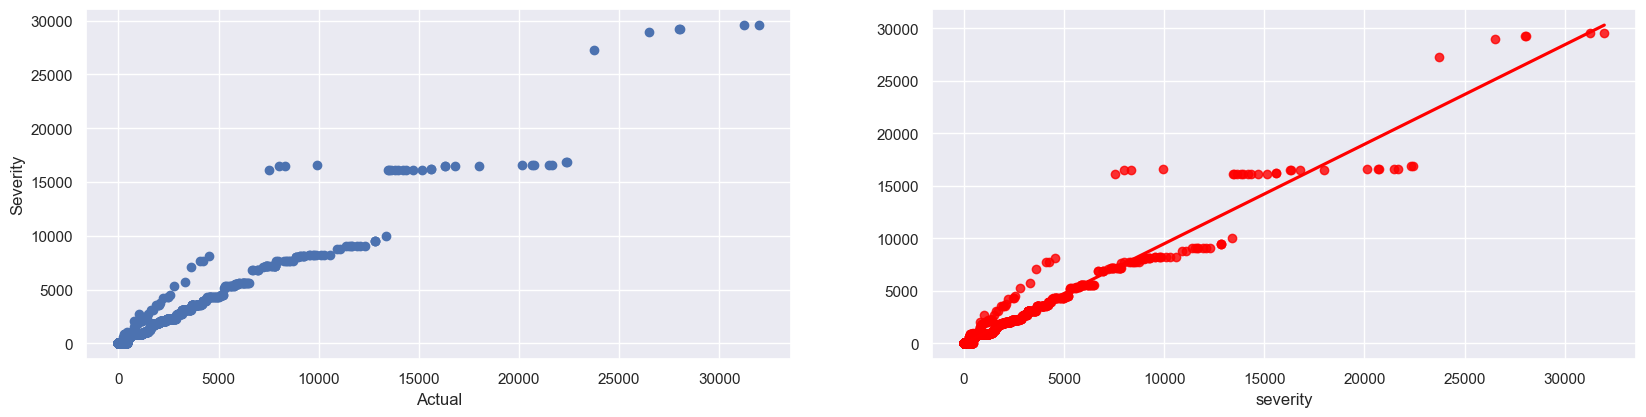

In [30]:
plt.subplot(221)
plt.scatter(ytest,y_pred);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=y_pred,ci=None,color ='red');

In [31]:
importance=pd.concat([pd.DataFrame(AdaBoostRegressor_model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(AdaBoostRegressor_model.feature_importances_,columns=["feature_importances"])],axis=1)

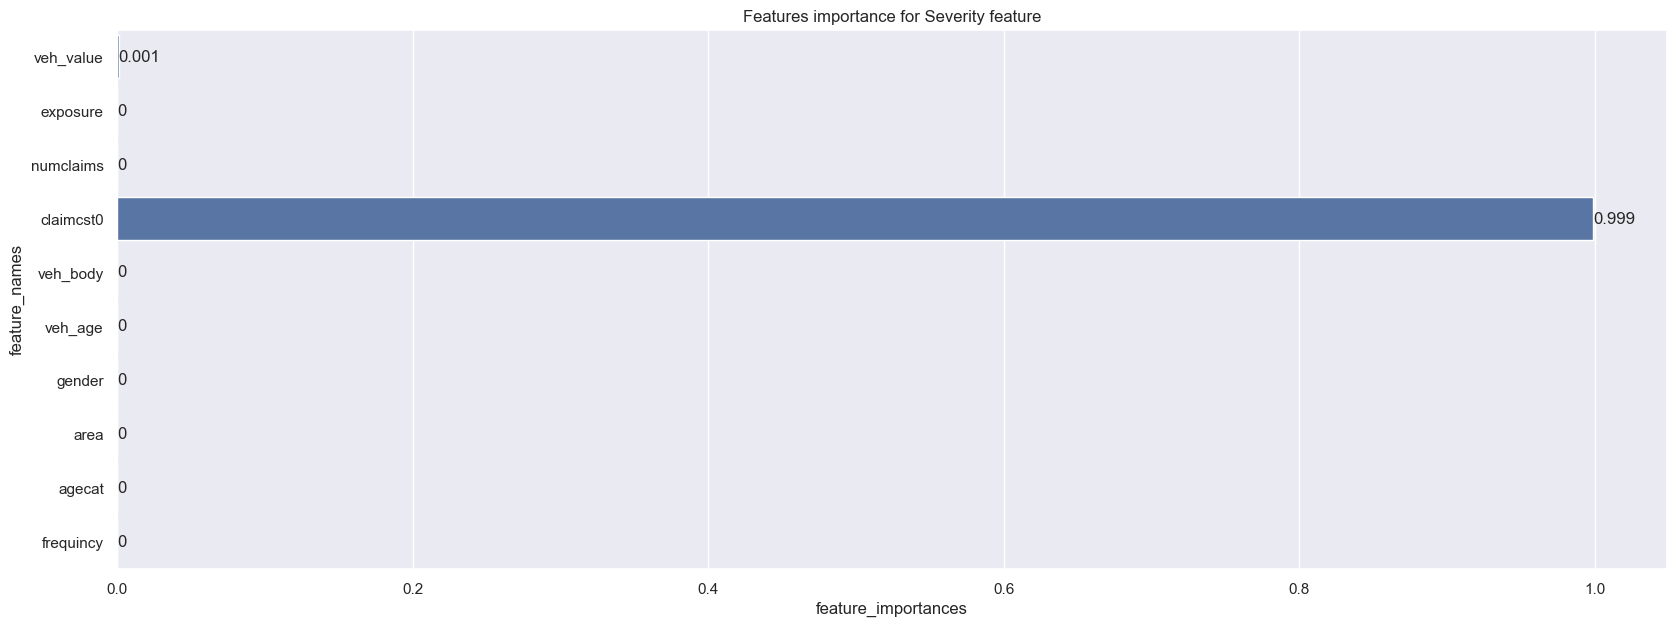

In [32]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Severity feature')
ax.bar_label(ax.containers[0]);

In [33]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/Severity_final_model.pkl","wb") as f:
    pickle.dump(AdaBoostRegressor_model,f)

---